In [2]:
import numpy as np
import matplotlib.pyplot as plt

import string

from models import ContinuousIncrementalRSA
from utils import *
import time
from tqdm import tqdm

# Iterated RSA
## Example 1: fix objects, utterances, semantic values and alpha 

The approach to modeling convergence to a convention is as follows:

- Initialize a `ContinuousIncrementalRSA` object. __This assumes that the objects, utterances, semantic values and alpha are all fixed, which is an assumption that we eventually will want to relax.__
- Initialize a list `counts` to keep track of the number of times a particular type of utterance (*adj-noun, noun-adj, adj only, noun only*) is produced by a pragmatic speaker.

- For each iteration:
    - For a given object, the speaker will produce a probability distribution over utterance types using continuous incremental RSA
    - Reweight that distribution by using the normalized version of `counts`
    - Sample from the reweighted distribution. 
    - Increment the utterance type that is sampled in `counts`

In [9]:
adjectives = ["red", "blue", "green", "purple"]
nouns = ["pin", "dress", "truck", "hat"]#, "bottle", "pen", "glasses"]
objects = get_all_objects(adjectives, nouns)
utterances = get_all_utterances(adjectives, nouns)
v_adj = 0.9
v_noun = 0.95
alpha = 5

In [10]:
rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                  nouns=nouns,
                                  objects=objects,
                                  utterances=utterances,
                                  v_adj=v_adj,
                                  v_noun=v_noun,
                                  alpha=alpha,
                                  cost_coef=cost)

In [11]:
p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

print('P(\'red\'| red dress) =', p_red)
print('P(\'dress\'| red dress) =', p_dress)
print('P(\'red dress\'| red dress) =', p_red_dress)
print('P(\'dress red\'| red dress) =', p_dress_red)

P('red'| red dress) = 0.0006706276047625377
P('dress'| red dress) = 0.0027431833134974005
P('red dress'| red dress) = 0.32994076987288
P('dress red'| red dress) = 0.6665935451798687


In [12]:
NUM_UTT_TYPES = 4
NUM_SIMS = 100
NUM_GENS = 300

runs = np.zeros(shape=(NUM_UTT_TYPES, NUM_SIMS, NUM_GENS))

for sim_idx in tqdm(range(NUM_SIMS)):
    start = time.time()
    counts = [1, 1, 1, 1]
    for gen_idx in range(NUM_GENS):
        
        #p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
        #p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
        #p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
        #p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

        utterance_type_prior = [count/sum(counts) for count in counts]
        probs = [p_red, p_dress, p_red_dress, p_dress_red]        

        #print('P(\'red\'| red dress) =', p_red)
        #print('P(\'dress\'| red dress) =', p_dress)
        #print('P(\'red dress\'| red dress) =', p_red_dress)
        #print('P(\'dress red\'| red dress) =', p_dress_red)

        denom = sum([utterance_type_prior[i]*probs[i] for i in range(4)])

        indices = list(range(4))
        normalized_probs = [(utterance_type_prior[i]*probs[i])/denom for i in range(4)]

        sample = np.random.choice(indices, p=normalized_probs)
        counts[sample] += 1

        for utt_idx in range(4):
            runs[utt_idx, sim_idx, gen_idx] = normalized_probs[utt_idx]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 165.45it/s]


In [13]:
means = []
stds = []
for i in range(4):
    mean = np.mean(runs[i], axis=0)
    std = np.std(runs[i], axis=0)
    means.append(mean)
    stds.append(std)

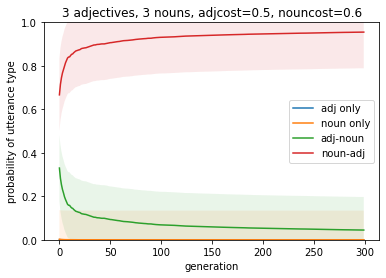

In [14]:
labels = ['adj only', 'noun only', 'adj-noun', 'noun-adj']
for i in range(0, 4):
    plt.plot(range(len(means[i])), means[i], label=labels[i])
    plt.fill_between(range(len(means[i])), means[i]+std[i], means[i]-std[i], alpha=0.1)
    
plt.legend()
plt.title("3 adjectives, 3 nouns, adjcost=0.5, nouncost=0.6")
plt.ylim([0, 1])
plt.xlabel('generation')
plt.ylabel('probability of utterance type')
plt.show()

Text(0, 0.5, 'frequency')

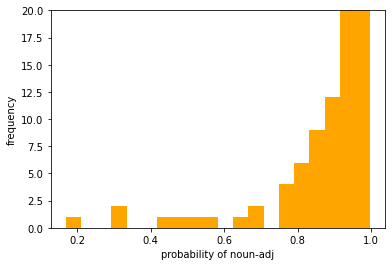

In [8]:
final_prob_of_noun_adj = runs[3, :, -1]
plt.hist(final_prob_of_noun_adj, bins=20, color='orange')
plt.ylim([0, 20])
plt.xlabel('probability of noun-adj')
plt.ylabel('frequency')

In [ ]:
np.sum(final_prob_of_noun_adj < 0.5)

## Example 2: Sample semantic values

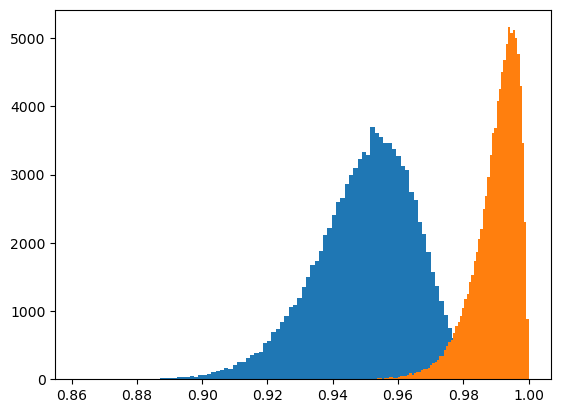

In [7]:
samples = np.random.beta(95/0.5, 5/0.5, 100000)
plt.hist(samples, bins=100)
samples = np.random.beta(99/0.5, 1/0.5, 100000)
plt.hist(samples, bins=100)
plt.show()

In [11]:
NUM_UTT_TYPES = 4
NUM_SIMS = 1000
NUM_GENS = 300

runs = np.zeros(shape=(NUM_UTT_TYPES, NUM_SIMS, NUM_GENS))

for sim_idx in tqdm(range(NUM_SIMS)):
    
    start = time.time()
    counts = [1, 1, 1, 1]
    for gen_idx in range(NUM_GENS):
        v_adj = np.random.beta(95/0.5, 5/0.5)
        v_noun = np.random.beta(99/0.5, 1/0.5)
        rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                  nouns=nouns,
                                  objects=objects,
                                  utterances=utterances,
                                  v_adj=v_adj,
                                  v_noun=v_noun,
                                  alpha=alpha)
        
        p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
        p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
        p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
        p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

        utterance_type_prior = [count/sum(counts) for count in counts]
        probs = [p_red, p_dress, p_red_dress, p_dress_red]        

        #print('P(\'red\'| red dress) =', p_red)
        #print('P(\'dress\'| red dress) =', p_dress)
        #print('P(\'red dress\'| red dress) =', p_red_dress)
        #print('P(\'dress red\'| red dress) =', p_dress_red)

        denom = sum([utterance_type_prior[i]*probs[i] for i in range(NUM_UTT_TYPES)])

        indices = list(range(NUM_UTT_TYPES))
        normalized_probs = [(utterance_type_prior[i]*probs[i])/denom for i in range(NUM_UTT_TYPES)]

        sample = np.random.choice(indices, p=normalized_probs)
        counts[sample] += 1

        for utt_idx in range(NUM_UTT_TYPES):
            runs[utt_idx, sim_idx, gen_idx] = normalized_probs[utt_idx]

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

  0%|                                                                                | 1/1000 [00:33<9:19:36, 33.61s/it]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206


  0%|▏                                                                               | 2/1000 [01:07<9:20:55, 33.72s/it]

207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
18

  0%|▏                                                                               | 3/1000 [01:41<9:19:39, 33.68s/it]

286
287
288
289
290
291
292
293
294
295
296
297
298
299
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

  0%|▎                                                                               | 4/1000 [02:15<9:21:02, 33.80s/it]

292
293
294
295
296
297
298
299
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
26

  0%|▍                                                                               | 5/1000 [02:49<9:23:18, 33.97s/it]

284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


  1%|▍                                                                               | 6/1000 [03:23<9:22:01, 33.93s/it]

261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
23

  1%|▍                                                                              | 6/1000 [03:50<10:37:48, 38.50s/it]


KeyboardInterrupt: 

In [ ]:
means = []
stds = []
for i in range(4):
    mean = np.mean(runs[i], axis=0)
    std = np.std(runs[i], axis=0)
    means.append(mean)
    stds.append(std)

In [ ]:
labels = ['red', 'pin', 'red pin', 'pin red']
labels = ['adj', 'noun', 'adj-noun', 'noun-adj']
for i in range(2, 4):
    plt.plot(range(len(means[i])), means[i], label=labels[i])
    plt.fill_between(range(len(means[i])), means[i]+std[i], means[i]-std[i], alpha=0.1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.legend(fontsize=14)
plt.ylim([0, 1])
plt.xlabel('generation', fontsize=14)
plt.ylabel('probability of utterance', fontsize=14)
#plt.savefig('evolution.png')
plt.show()

In [ ]:
final_prob_of_noun_adj = runs[3, :, -1]
plt.hist(final_prob_of_noun_adj, bins=20, color='orange')
#plt.ylim([0, 20])
plt.xlim([0, 1])
plt.xlabel('P(noun-adj)', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
np.sum(final_prob_of_noun_adj < 0.48)

In [ ]:
np.sum((final_prob_of_noun_adj < 0.52) & (final_prob_of_noun_adj >= 0.48))

In [ ]:
np.sum(final_prob_of_noun_adj >= 0.52)

## Example 3: Sample semantic values and contexts

In [ ]:
possible_adjectives = ['red', 'orange', 'yellow', 'green', 'blue']
possible_nouns = ['dress', 'pin', 'car', 'table', 'boat']

In [ ]:
cached_objects = {}
cached_utterances = {}
for i in range(1, len(possible_adjectives)):
    for j in range(1, len(possible_nouns)):
        adj_subset = possible_adjectives[:i+1]
        noun_subset = possible_nouns[:j+1]
        cached_objects[(i, j)] = get_all_objects(adj_subset, noun_subset)
        cached_utterances[(i, j)] = get_all_utterances(adj_subset, noun_subset)

In [ ]:
cached_utterances

In [ ]:
runs = np.zeros(shape=(4, 100, 300))

for sim_idx in tqdm(range(100)):
    
    start = time.time()
    counts = [1, 1, 1, 1]
    for gen_idx in range(300):
        num_adj = np.random.randint(low=1, high=len(possible_adjectives))
        num_noun = np.random.randint(low=1, high=len(possible_nouns))
        
        adj_subset = possible_adjectives[:num_adj]
        noun_subset = possible_nouns[:num_noun]
        
        objects = cached_objects[(num_adj, num_noun)]
        utterances = cached_utterances[(num_adj, num_noun)]
        
        v_adj = get_v_adj()
        v_noun = get_v_noun()
        rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                  nouns=nouns,
                                  objects=objects,
                                  utterances=utterances,
                                  v_adj=v_adj,
                                  v_noun=v_noun,
                                  alpha=alpha)
        
        p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
        p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
        p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
        p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

        utterance_type_prior = [count/sum(counts) for count in counts]
        probs = [p_red, p_dress, p_red_dress, p_dress_red]        

        #print('P(\'red\'| red dress) =', p_red)
        #print('P(\'dress\'| red dress) =', p_dress)
        #print('P(\'red dress\'| red dress) =', p_red_dress)
        #print('P(\'dress red\'| red dress) =', p_dress_red)

        denom = sum([utterance_type_prior[i]*probs[i] for i in range(4)])

        indices = list(range(4))
        normalized_probs = [(utterance_type_prior[i]*probs[i])/denom for i in range(4)]

        sample = np.random.choice(indices, p=normalized_probs)
        counts[sample] += 1

        for utt_idx in range(4):
            runs[utt_idx, sim_idx, gen_idx] = normalized_probs[utt_idx]

In [ ]:
truncated_runs = runs[:, :66, :]
truncated_runs.shape

In [ ]:
means = []
stds = []
for i in range(4):
    mean = np.mean(truncated_runs[i], axis=0)
    std = np.std(truncated_runs[i], axis=0)
    means.append(mean)
    stds.append(std)

In [ ]:
labels = ['red', 'pin', 'red pin', 'pin red']
for i in range(2, 4):
    plt.plot(range(len(means[i])), means[i], label=labels[i])
    plt.fill_between(range(len(means[i])), means[i]+std[i], means[i]-std[i], alpha=0.1)
    
plt.legend()
plt.ylim([0, 1])
plt.xlabel('generation')
plt.ylabel('probability of utterance type')
plt.show()

In [ ]:
final_prob_of_noun_adj = truncated_runs[3, :, -1]
plt.hist(final_prob_of_noun_adj, bins=20, color='orange')
plt.ylim([0, 20])
plt.xlabel('probability of pin red')
plt.ylabel('frequency')

In [ ]:
np.sum(final_prob_of_noun_adj > 0.5)/66